# Dependencies

In [51]:
pip install tensorflow-datasets

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

# Auxiliary functions /code

In [53]:
def count_n_images_iterator(this_iterator, name, what='images'):
  count_items = 0
  for item, label in this_iterator:
        count_items += 1

  print(f'The {name} dataset has {count_items} {what}.')

In [54]:
def plot_acuracy_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


# Load Data

In [55]:
split0, split1, split2 = tfds.even_splits('train', n=3)

In [56]:
ds_train, ds_info = tfds.load('caltech101', split=split0, shuffle_files=False, as_supervised=True, with_info=True)

In [57]:
ds_test, __ = tfds.load('caltech101', split=split1, shuffle_files=False, as_supervised=True, with_info=True)

In [58]:
ds_val, __ = tfds.load('caltech101', split=split2, shuffle_files=False, as_supervised=True, with_info=True)

# Data information

In [59]:
print(ds_info)

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='/root/tensorflow_datasets/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'),
    disable_

O dataset consiste em imagens de objetos que pertencem a 101 classes. Cada imagem é rotulada com um único objeto e cada classe contém cerca de 40 a 800 imagens, totalizando cerca de 9 mil imagens.

# Explore the data

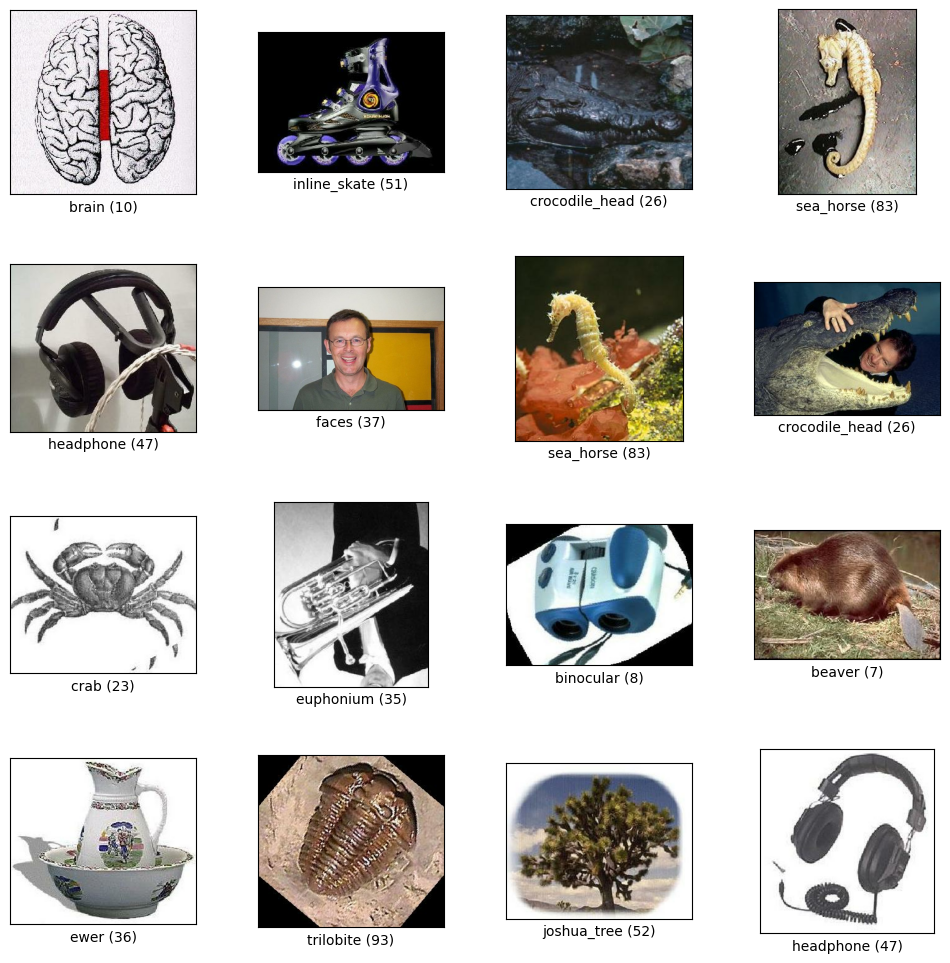

In [60]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

O dataset contém imagens com diferentes cores, formas e tamanho, por isso precisam de ser convertidos para a mesma altura e largura.

O dataset tem cor, por isso tem 3 canais.


# Transform Data

# Create a sub sample

In [61]:
count_n_images_iterator(ds_train, 'train'),
count_n_images_iterator(ds_test, 'test'),
count_n_images_iterator(ds_val, 'validation')

The train dataset has 1020 images.
The test dataset has 1020 images.
The validation dataset has 1020 images.


In [62]:
sub_ds_train = ds_train.take(800)
sub_ds_test = ds_test.take(200)
sub_ds_val = ds_val.take(300)

In [63]:
count_n_images_iterator(sub_ds_train, 'train'),
count_n_images_iterator(sub_ds_test, 'test'),
count_n_images_iterator(sub_ds_val, 'validation')

The train dataset has 800 images.
The test dataset has 200 images.
The validation dataset has 300 images.


#Normalize data

In [64]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) /255.0, label

In [65]:
normalize_ds_train = sub_ds_train.map(normalize_image)
normalize_ds_test = sub_ds_test.map(normalize_image)
normalize_ds_val = sub_ds_val.map(normalize_image)

# Resize images

In [66]:
def resize_image(image, label, target_height=200, target_width=200):
    return tf.image.resize_with_pad(image, target_height, target_width), label

In [67]:
resized_ds_train = normalize_ds_train.map(resize_image)
resized_ds_test = normalize_ds_test.map(resize_image)
resized_ds_val = normalize_ds_val.map(resize_image)

In [68]:
count_n_images_iterator(resized_ds_train, 'train'),
count_n_images_iterator(resized_ds_test, 'test'),
count_n_images_iterator(resized_ds_val, 'validation')

The train dataset has 800 images.
The test dataset has 200 images.
The validation dataset has 300 images.


# Data after transformation

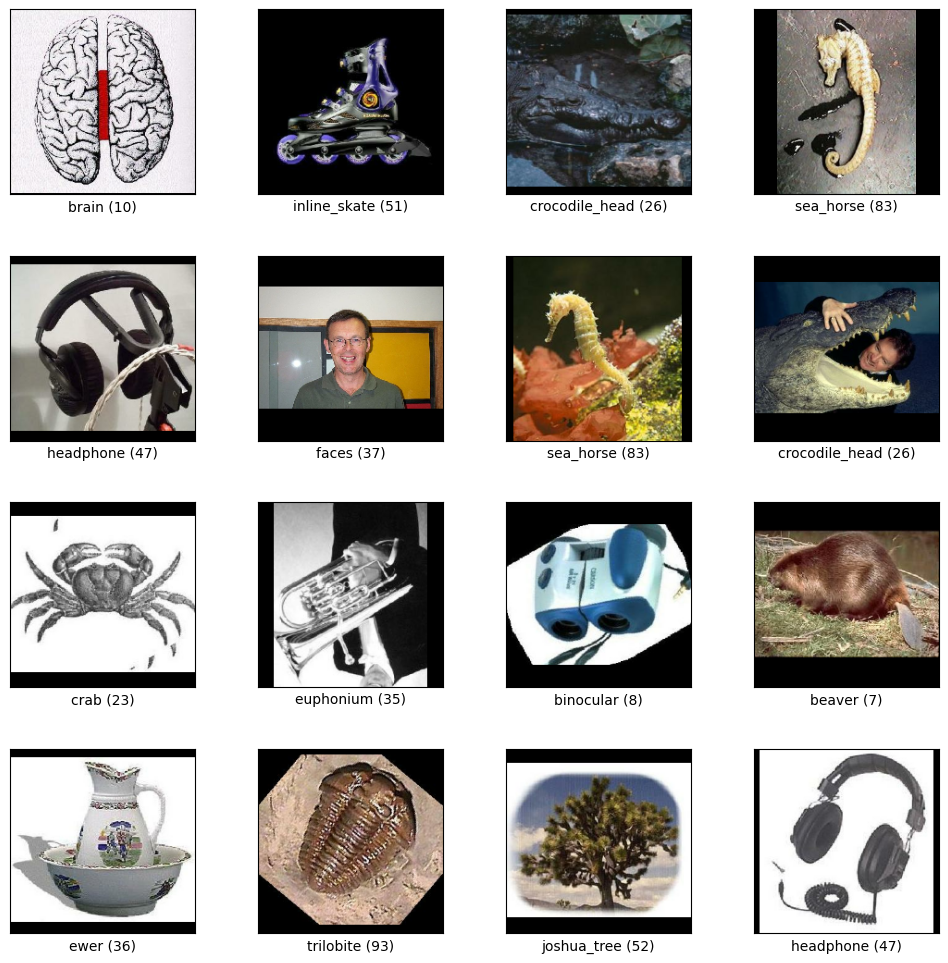

In [19]:
fig = tfds.show_examples(resized_ds_train, ds_info, rows=4, cols=4)

# Define batch size

In [69]:
resized_ds_train = resized_ds_train.batch(256)
resized_ds_test = resized_ds_test.batch(256)
resized_ds_val = resized_ds_val.batch(256)

In [70]:
count_n_images_iterator(resized_ds_train, 'train', 'batches'),
count_n_images_iterator(resized_ds_test, 'test', 'batches'),
count_n_images_iterator(resized_ds_val, 'validation', 'batches')

The train dataset has 4 batches.
The test dataset has 1 batches.
The validation dataset has 2 batches.



No dataset de treino temos 4 grupos de imagens
No dataset de teste temos 1 grupo de imagens
No dataset de validaçao temos 2 grupos de imagens

# Problem definition

## Objective

## Metric

Currently using 'accuracy'.

# Modeling

Vamos fazer o Baseline model pois é um modelo simples que serve como uma linha de base para comparação com modelos mais complexos
E de seguida o l2_model que é um modelo que incorpora regularização L2 nas camadas densas.
A regularização L2 adiciona um termo à função de perda do modelo, penalizando os pesos maiores e incentivando pesos menores, o que ajuda a evitar o overfitting.
No final, temos um termo de comparação dos dois modelos


## Baseline model

In [102]:
dataset_info = tfds.builder('caltech101')
num_classes = dataset_info.info.features['label'].num_classes

baseline_model = Sequential([
  layers.Input(shape=(200, 200, 3)),
  layers.Flatten(),
  layers.Dense(300, activation='relu'),
  layers.Dense(100, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


*   num_classes = dataset_info.features['label'].num_classes: Esta linha de código extrai o número de classes do conjunto de dados Caltech 101. A chave 'label' é usada para aceder a informação relacionada às categorias de rótulos (ou classes) presentes no conjunto de dados. num_classes é então atribuído ao número de classes presentes no conjunto de dados.

In [103]:
baseline_model.compile(optimizer='adam',  # Otimizador Adam
                       loss='sparse_categorical_crossentropy',  # Função de perda para classificação
                       metrics=['accuracy'])  # Métrica de avaliação: precisão

In [104]:
baseline_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 120000)            0         
                                                                 
 dense_48 (Dense)            (None, 300)               36000300  
                                                                 
 dense_49 (Dense)            (None, 100)               30100     
                                                                 
 dense_50 (Dense)            (None, 10)                1010      
                                                                 
 dense_51 (Dense)            (None, 102)               1122      
                                                                 
Total params: 36032532 (137.45 MB)
Trainable params: 36032532 (137.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
epochs=10
history = baseline_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 9s 1s/step - loss: 15.5284 - accuracy: 0.0088 - val_loss: 4.6250 - val_accuracy: 0.0100
Epoch 2/10
4/4 [==============================] - 9s 2s/step - loss: 4.6247 - accuracy: 0.0150 - val_loss: 4.6249 - val_accuracy: 0.0100
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 4.6243 - accuracy: 0.0150 - val_loss: 4.6250 - val_accuracy: 0.0100
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 4.6239 - accuracy: 0.0150 - val_loss: 4.6251 - val_accuracy: 0.0100
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 4.6236 - accuracy: 0.0150 - val_loss: 4.6252 - val_accuracy: 0.0100
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 4.6232 - accuracy: 0.0150 - val_loss: 4.6252 - val_accuracy: 0.0100
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 4.6228 - accuracy: 0.0150 - val_loss: 4.6253 - val_accuracy: 0.0100
Epoch 8/10
4/4 [========================

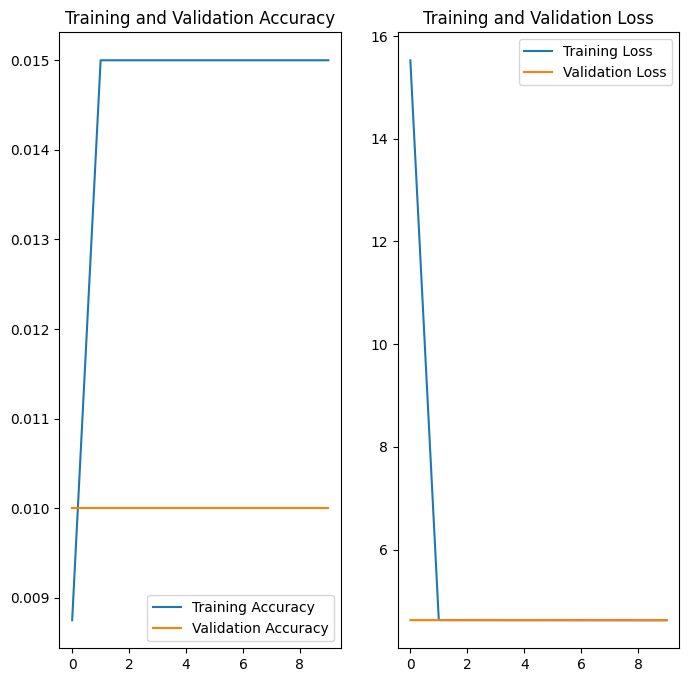

In [106]:
plot_acuracy_loss(history)

## Add L2 Regularization
On top of the dropout

In [94]:
kernel_regularizer = tf.keras.regularizers.L2(0.01)

In [95]:


l2_model = Sequential([
  layers.Input(shape=(200, 200, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(num_classes, activation='softmax')
])

utilizamos softmax em vez de linear pois é mais adequada para problemas de classificação multiclasse, onde pretendemos prever a probabilidade de cada classe.
O problema de classificação do conjunto de dados Caltech101, é um problema de classificação multiclasse, a camada de saída deve ser a ativação softmax. Se fosse  um problema de regressão, onde pretendemos prever um valor contínuo, poderíamos usar a ativação linear

In [96]:
l2_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

A escolha entre sparse_categorical_crossentropy e BinaryCrossentropy depende da natureza do problema que você está tentando resolver.

Se o seu problema for uma tarefa de classificação com mais de duas classes (ou seja, classificação multiclasse), é comum usar a função de perda sparse_categorical_crossentropy. Essa função de perda espera que seus rótulos de destino sejam fornecidos como inteiros (por exemplo, 0, 1, 2, ...) e converte automaticamente esses inteiros em uma codificação one-hot para calcular a perda.
Por outro lado, se o seu problema for uma tarefa de classificação binária (ou seja, apenas duas classes), você pode usar a função de perda BinaryCrossentropy. Essa função de perda é adequada para problemas binários e espera que os rótulos de destino sejam fornecidos como valores contínuos entre 0 e 1 (representando as probabilidades das classes). O argumento from_logits=True indica que as saídas do modelo não passaram pela função softmax, ou seja, as saídas são logits (pontuações antes de serem transformadas em probabilidades pela softmax).
No caso do conjunto de dados Caltech101, que é um problema de classificação multiclasse, usamos sparse_categorical_crossentropy porque temos várias classes para prever. Isso requer que os rótulos de destino sejam fornecidos como inteiros e a função de perda fará a conversão internamente.



In [97]:
l2_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 100, 100, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 100, 100, 16)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_61 (Dropout)        (None, 50, 50, 32)       

In [98]:
epochs=20
history = l2_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/20
4/4 [==============================] - 38s 9s/step - loss: 4.9317 - accuracy: 0.0137 - val_loss: 4.8663 - val_accuracy: 0.0067
Epoch 2/20
4/4 [==============================] - 36s 8s/step - loss: 4.8454 - accuracy: 0.0162 - val_loss: 4.8396 - val_accuracy: 0.0033
Epoch 3/20
4/4 [==============================] - 35s 8s/step - loss: 4.8014 - accuracy: 0.0113 - val_loss: 4.8070 - val_accuracy: 0.0033
Epoch 4/20
4/4 [==============================] - 34s 8s/step - loss: 4.7412 - accuracy: 0.0262 - val_loss: 4.7798 - val_accuracy: 0.0100
Epoch 5/20
4/4 [==============================] - 36s 9s/step - loss: 4.6551 - accuracy: 0.0288 - val_loss: 4.7567 - val_accuracy: 0.0167
Epoch 6/20
4/4 [==============================] - 45s 10s/step - loss: 4.5772 - accuracy: 0.0475 - val_loss: 4.8028 - val_accuracy: 0.0133
Epoch 7/20
4/4 [==============================] - 39s 9s/step - loss: 4.4946 - accuracy: 0.0637 - val_loss: 4.7164 - val_accuracy: 0.0400
Epoch 8/20
4/4 [=================

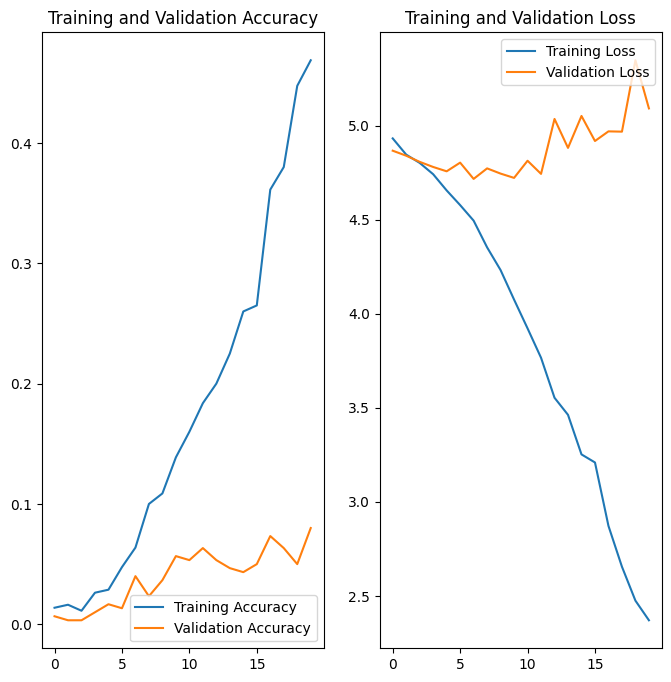

In [99]:
plot_acuracy_loss(history)

Aumentamos o numero de ephocs para melhorar a precisao do modelo
Se estiver em overfitting podemos diminuir a regularizaçao de l2 para 0.001
Podiamos aumentar o numero de dados de treino

In [100]:
epochs=30
history = l2_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
4/4 [==============================] - 38s 9s/step - loss: 2.1965 - accuracy: 0.5150 - val_loss: 5.4346 - val_accuracy: 0.0600
Epoch 2/30
4/4 [==============================] - 34s 8s/step - loss: 2.0147 - accuracy: 0.5500 - val_loss: 5.1630 - val_accuracy: 0.0900
Epoch 3/30
4/4 [==============================] - 37s 8s/step - loss: 1.8094 - accuracy: 0.6162 - val_loss: 5.4316 - val_accuracy: 0.0667
Epoch 4/30
4/4 [==============================] - 36s 9s/step - loss: 1.6425 - accuracy: 0.6712 - val_loss: 5.5487 - val_accuracy: 0.0800
Epoch 5/30
4/4 [==============================] - 42s 10s/step - loss: 1.4872 - accuracy: 0.7100 - val_loss: 5.9710 - val_accuracy: 0.0733
Epoch 6/30
4/4 [==============================] - 38s 9s/step - loss: 1.4247 - accuracy: 0.7175 - val_loss: 5.7409 - val_accuracy: 0.0800
Epoch 7/30
4/4 [==============================] - 34s 8s/step - loss: 1.2663 - accuracy: 0.7625 - val_loss: 6.2903 - val_accuracy: 0.0667
Epoch 8/30
4/4 [=================

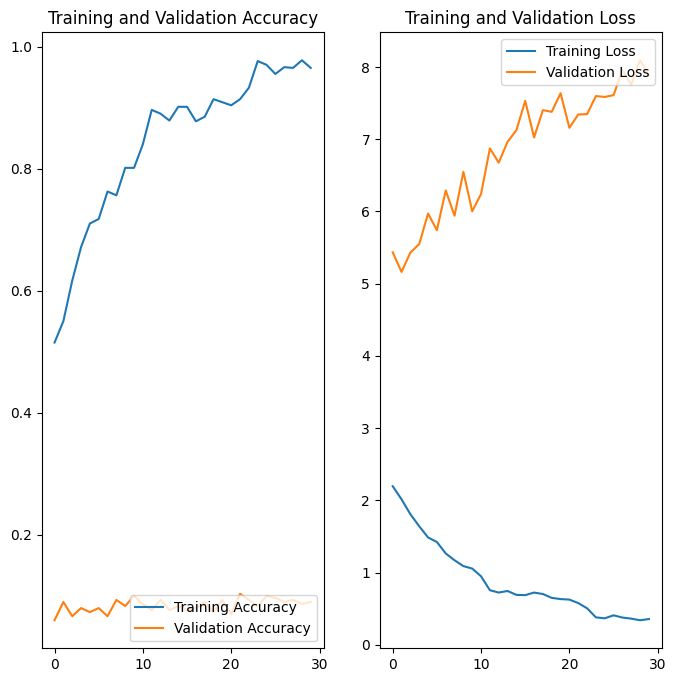

In [101]:
plot_acuracy_loss(history)